# Demonstration of the experiments for reproducibility

Article: "Improving Machine Hearing on Limited Data Sets" <br> 
Authors: P. Harar, R. Bammer, A. Breger, M. Dörfler and Z. Smekal

# Summary

In this notebook, we prepared the Good Sounds data. All audio files were stripped of the silence using Sox, split into Tukey windowed segments of equal duration according to config parameters. These files were saved to disk and metadata about them were saved to csv_preprocessed.

Next, these segments were splitted into stratified train, validation and test sets with specified number of samples from each class in test and valid sets and the rest of non_leaking segments in train set. Metadata are saved in csv_split.

Segments were transformed into desired time-frequency representation according to csv_split which was shuffled and splitted to batches of equal size with the last batch containing all remaining samples. Batches were saved to disk as .npz files for fast loading. Metadata were saved to batches.csv in appropriate folders.

TimeFrequencySequence object will load and return appropriate batch based on its index. If the batch was removed from disk before initialization of the object, it will be created again.

Then the Convolutional Neural Network model was created in Keras. In this experiment, we did not do any exhaustive hyperparameter optimization, but we used the knowledge from our previous experiments published in another paper. All models were trained for the same amount of weight updates with early stopping callback.

# Outline

1. Config
1. Downloading and preparing the Good Sounds database
1. Preprocessing of the wav files (removing silence and splitting into segments)
1. Splitting into stratified train/validation/test sets
1. Loading split metadata from a file
1. Definition of customized loss function
1. Preparing labels and output-space features for training
1. Creating train/validation/test sequences (and batching)
1. Visualization of some of the training data
1. Definition of the Convolutional Neural Network model
1. Training the model
1. Evaluate the experiment outputs

In [1]:
##############################
# Reproducibility
# In order to be able to reproduce the results we need to set random seeds.
# But, due to usage of multiprocessing and GPU computation it is not possible
# to get the exact same results each time the experiment is run.
# One would need to compute the whole experiment on 1 CPU which is noc feasible.

import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ["CUDA_VISIBLE_DEVICES"]="1"
np.random.seed(1602)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=0, inter_op_parallelism_threads=0)
# session_conf.gpu_options.allow_growth=True
from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
#############################

# Generic
%matplotlib inline
import zipfile
import pandas as pd
import urllib.request
from src.utils import *
from src.sqlite_to_csv import convert_to_csv
from subprocess import check_output
from multiprocessing import Pool, cpu_count

# DNN
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.initializers import glorot_uniform as gu
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Activation, Flatten, Reshape, Dropout, Permute, Concatenate
from keras.layers import Conv2D, AveragePooling2D, LocallyConnected2D, GlobalMaxPooling2D

Using TensorFlow backend.


# 1. Configuration

In [ ]:
# Configure paths
on_ssd = 'data/good_sounds/'
paths = {
    # Path to directory where to download the dataset
    'path_download': on_ssd,
    
    # Path to folder where csvs converted from sqlite will be stored
    'path_original_csvs': os.path.join(on_ssd, 'database_csvs'),
    
    # Path to csv with list of all audio files will be stored
    'path_csv_original': os.path.join(on_ssd, 'good_sounds_meta.csv'),
    
    # Path where the train-ready labels for each class reside
    'path_csv_labels': 'good_sounds_labels.csv',

    # Path for saving preprocessed files (ideally on SSD otherwise saving can take a long time)
    'path_preprocessed': os.path.join(on_ssd, 'preprocessed'),
    
    # Path for saving csv of preprocessed files
    'path_csv_preprocessed': os.path.join(on_ssd, 'preprocessed/preprocessed.csv'),
    
    # Path for saving csv of metadata split into train/valid/test sets
    'path_csv_split': os.path.join(on_ssd, 'preprocessed/split.csv'),
    
    # Path for saving ready batches for fast loading (on SSD!)
    'path_cache': os.path.join(on_ssd, 'batch_cache'),
    
    # Path for saving expriment results
    'path_experiments': 'experiments',
}

In [3]:
# Configure wave preprocessing, equalization and splitting parameters

params = {
    # Preparing segments
    'sample_dur_s': 1.0,
    'rate': 44100,  # Output rate of sox silence removal
    'overwrite': False,  # Overwrite previous files on disk during splitting to segments

    # Equalization using variable stride
    # The 'stride_perc' must be either one number or dictionary mapping
    # class names to a float. If one number, uses same stride for all classes.
    # Classes not present in dict will be ommited completely.
    'stride_perc': {'clarinet': 86.140, 'flute': 62.159, 'trumpet': 51.759, 
                    'violin': 44.979, 'sax_alto': 44.135, 'cello': 36.243},

    'window': True,  # Tukey window with alpha 0.25

    # Splitting
    # Using fixed number of samples for test and valid.
    # All other samples without the leaky ones are used for training.
    'n_valid': 4000,  # per class
    'n_test': 4000,  # per class
}

In [4]:
sample_params = {
    'dur': params['sample_dur_s'], 
    'rate': params['rate']
}


tfparams = {
    'GS': {
        'l1_params' : {'nfft': 2000, 'nperseg': 2000, 'noverlap': 1750},
        'l2_params' : {'nfft': 25, 'nperseg': 25, 'noverlap': 20},
        'o2_params' : {'window_len': 5, 'mode': 'same', 'axis':1},
        'shapes' : {'outA': (480, 160), 'outB': (480, 160), 'outC': (480, 160)},
        'return_outA': True,
        'return_outB': True, 
        'return_outC': True,
    },

    'MS': {
        'mel_params' : {'n_mels': 100},
        'l1_params' : {'nfft': 2000, 'nperseg': 2000, 'noverlap': 1750},
        'l2_params' : {'nfft': 25, 'nperseg': 25, 'noverlap': 20},
        'o2_params' : {'window_len': 5, 'mode': 'same', 'axis':1},
        'shapes' : {'outA': (120, 160), 'outB': (120, 160), 'outC': (120, 160)},
        'return_outA': True,
        'return_outB': True, 
        'return_outC': True,
    },
    
    'MT': {
        'mel_params' : {'n_mels': 100},
        'l1_params' : {'nfft': 2000, 'nperseg': 2000, 'noverlap': 1750},
        'l2_params' : {'nfft': 25, 'nperseg': 25, 'noverlap': 20},
        'o2_params' : {'window_len': 5, 'mode': 'same', 'axis':1},
        'shapes' : {'outA': (120, 160), 'outB': (120, 160), 'outC': (120, 160)},
        'return_outA': True,
        'return_outB': False, 
        'return_outC': False,
    },
}

shapes = {
    'GS': (3, 480, 160),
    'MS': (3, 120, 160),
    'MT': (1, 120, 160) 
}

In [5]:
# Configure some of the training hyper-parameters

train_params = {
    'batch_size': 128,
    'scaling': None,  # One of {None, 'log'}
    'rep': None,  # One of {'raw', 'GS', 'MT', 'MS'}, will be set in particular experiment
    'separate_inputs': False, # (returns list of 2d arrays instead of 3dim numpy array)
    'weight_updates': 11000, # Will be used to compute no. of epochs
    'verbose': 1,

    'shuffle': True,
    'seed': 5610,
    'initial_epoch': 0,
    
    # Set keep_in_ram to True, if training, validation and testing sets together
    # fit in your available RAM. Created batches will be saved to disk anyways.
    # In this case, you need to pregenerate batches before running the training.
    # Each Keras Sequence will load all batches in ramcache and then use those, 
    # which is much faster then even loading from SSD of course.
    'keep_in_ram': False,
    
    # If keep_in_ram is True, turn off multiprocessing and set workers to 1
    'workers': 16,
    'max_queue_size': 32,
    'use_multiprocessing': True,
}

# 2. Downloading and preparing the Good Sounds database

In [9]:
# Download the Good Sounds dataset (13.9 GB)
# We have used the Version 1. of the dataset from 29 Jun 2017
# Website for manual download here: https://zenodo.org/record/820937
# Zip file checksum md5: 2137bbb2d32c1d60aa51e1301225f541

print('Download started ...')
url = 'https://zenodo.org/record/820937/files/good-sounds.zip?download=1'
ensure_folder(paths['path_download'])
urllib.request.urlretrieve(url, os.path.join(paths['path_download'], 'good-sounds.zip'))
print('Download complete.')

Download started ...
Download complete.


In [6]:
# Unpack the archive
print('Unpacking the archive ...')
zf = zipfile.ZipFile(os.path.join(paths['path_download'], 'good-sounds.zip'), 'r')
zf.extractall(path=paths['path_download'])
del zf # Clearing the memory
print('Unpacking complete.')
print('Delete the zip file manually to save space.')

Unpacking the archive ...
Unpacking complete.
Delete the zip file manually to save space.


In [11]:
# Convert sqlite metadata tables into csvs
print('Converting sqlite into csvs ...')
ensure_folder(paths['path_original_csvs'])
convert_to_csv(os.path.join(paths['path_download'], 'good-sounds' ,'database.sqlite'),
               paths['path_original_csvs'])
print('Converting complete.')

Converting sqlite into csvs ...
Converting complete.


In [12]:
# Merge csvs in one with all necessary information
print('Merging metadata into one csv ...')
sounds_csv = pd.read_csv(os.path.join(paths['path_original_csvs'], 'sounds.csv'),
                         usecols=['id', 'instrument'])
sounds_csv.columns = ['sound_id', 'instrument']  # Rename columns
takes_csv = pd.read_csv(os.path.join(paths['path_original_csvs'], 'takes.csv'),
                        usecols=['id', 'sound_id', 'filename'])
takes_csv = takes_csv[['id', 'sound_id', 'filename']]  # Reorder
takes_csv.columns = ['take_id', 'sound_id', 'filename']  # Rename columns
merged = pd.merge(sounds_csv, takes_csv, how='right', on='sound_id')
merged = merged[['take_id', 'sound_id', 'instrument', 'filename']]
merged.to_csv(paths['path_csv_original'], index=False)
del sounds_csv, takes_csv, merged  # Clearing the memory
print('Merging complete.')

Merging metadata into one csv ...
Merging complete.


# 3. Preprocessing of the wav files using multiprocessing

* Removing silence
* Splitting into segments using stride
* Apply Tukey window with alpha=0.25
* Splitting into train, validation, testing sets

### Output: paths['path_csv_preprocessed']

In [13]:
# Load the dataset metadata from a csv file
# Must contain ['take_id', 'sound_id', 'instrument', 'filename'] columns
csv_original = pd.read_csv(paths['path_csv_original'],
                           usecols=['take_id', 'sound_id', 'instrument', 'filename'])
csv_original.head()

take_id  sound_id instrument  \
0        1         1      flute   
1        2         1      flute   
2        3         1      flute   
3        5         2      flute   
4        6         2      flute   

                                            filename  
0  sound_files/flute_almudena_reference/akg/0000.wav  
1  sound_files/flute_almudena_reference/iphone/00...  
2  sound_files/flute_almudena_reference/neumann/0...  
3  sound_files/flute_almudena_reference/akg/0001.wav  
4  sound_files/flute_almudena_reference/iphone/00...

In [14]:
# Run the function prepare segments using multiprocessing
# Takes roughly 260s using AMD Ryzen 8-core cpu and SSD
# Without the SSD, your HDD's speed will be a bottleneck (can take e.g. 25 minutes)

if isinstance(params['stride_perc'], dict):
    # Select only classes that are specified
    csv = csv_original.loc[csv_original['instrument'].isin(
        params['stride_perc'].keys())]
else:
    # Use all classes available
    csv = csv_original

print('Computing...')
pool = Pool(processes=cpu_count())
dfs = pool.starmap(prepare_segments, zip(
    csv.iterrows(), repeat(paths), repeat(params)))

# Concat the results and save them as csv.
csv_preprocessed = pd.concat(dfs)
csv_preprocessed.to_csv(paths['path_csv_preprocessed'], index=False)

print('Done.')

Computing...
Done.


# 4. Splitting into stratified train/validation/test sets

Splitting dataframe into train, valid and test sets with fixed number of n_valid, n_test samples, all the rest non-leaky training samples are used.

**Output: paths['path_csv_split']**

In [ ]:
# Load the metadata about audio segments created in previous step
csv_preprocessed = pd.read_csv(paths['path_csv_preprocessed'])
csv_preprocessed.head()

In [16]:
# sis: helper df for stratification, sis stands for Sound_id segments
sis = csv_preprocessed['sound_id'].value_counts().to_frame(name='segments')
sis = sis.merge(csv_preprocessed[['sound_id', 'instrument']].drop_duplicates(
        subset='sound_id'), how='left', left_index=True, right_on='sound_id')

# Compute the sound_ids for each set

# Test sound_ids
tsi = enough_segments(sis, groupby_col='instrument', segments_col='segments',
                      return_col='sound_id', n=params['n_test'], mode='random')

# Valid sound_ids
vsi = enough_segments(sis.drop(sis.loc[sis['sound_id'].isin(tsi)].index), groupby_col='instrument',
                      segments_col='segments', return_col='sound_id', n=params['n_valid'], mode='random')
vsi = enough_segments(sis[~sis['sound_id'].isin(tsi)], groupby_col='instrument',
                      segments_col='segments', return_col='sound_id', n=params['n_valid'], mode='random')

# Train sound_ids
xsi = sis[~sis['sound_id'].isin(np.concatenate([tsi, vsi]))]['sound_id'].values
assert(len(tsi) + len(vsi) + len(xsi) == len(sis)
       ), 'Not all samples were used. There is bug somewhere.'

# Label everything as train
csv_preprocessed['set'] = 'train'

# Get n samples stratified by column 'instrument' and relabel them as 'test'
test = csv_preprocessed.loc[csv_preprocessed['sound_id'].isin(tsi)].groupby(
    'instrument', group_keys=False).apply(lambda x: x.sample(params['n_test'], random_state=10))
csv_preprocessed.loc[csv_preprocessed['sound_id'].isin(tsi), 'set'] = 'leaky'
csv_preprocessed.loc[test.index, 'set'] = 'test'

# Get other n samples stratified by column 'instrument' and relabel them as 'valid'
valid = csv_preprocessed.loc[csv_preprocessed['sound_id'].isin(vsi)].groupby(
    'instrument', group_keys=False).apply(lambda x: x.sample(params['n_valid'], random_state=10))
csv_preprocessed.loc[csv_preprocessed['sound_id'].isin(vsi), 'set'] = 'leaky'
csv_preprocessed.loc[valid.index, 'set'] = 'valid'

# Save the csv
csv_preprocessed.to_csv(paths['path_csv_split'], index=False)
print('Done.')

Done.


# 5. Loading split metadata from a file

In [ ]:
# Open csv with metadata about split segments
csv_split = pd.read_csv(paths['path_csv_split'])
csv_split.head()

In [7]:
# Get the segments counts of each set as a sanity check
csv_split['set'].value_counts()

train    70663
valid    24000
test     24000
leaky      184
Name: set, dtype: int64

In [8]:
# Get the segments counts of each instrument as a sanity check
csv_split.loc[csv_split['set'] == 'train', 'instrument'].value_counts()

sax_alto    12134
trumpet     11796
flute       11786
clarinet    11707
cello       11689
violin      11551
Name: instrument, dtype: int64

# 6. Definition of customized loss function
The code can be found in function ```custom_loss``` defined in file ```src/utils.py```.
This function contains both - categorical crossentropy loss and augmented target loss functions.
If the alpha parameter is set to 0, only categorical crossentropy loss is used.

# 7. Preparing labels and output-space features for training

* base_labels are used in categorical_crossentropy loss
* features are used in augmented target loss function

Categorical values are one-hot encoded. Nominal values are normalized so the max value is 1.

In [9]:
# Load labels from a csv
all_features = pd.read_csv(paths['path_csv_labels'], index_col='instrument')
base_labels = ['Y0_clarinet', 'Y0_flute', 'Y0_trumpet',
               'Y0_violin', 'Y0_sax_alto', 'Y0_cello']
labels = all_features[base_labels]
labels

Y0_clarinet  Y0_flute  Y0_trumpet  Y0_violin  Y0_sax_alto  \
instrument                                                              
clarinet              1         0           0          0            0   
flute                 0         1           0          0            0   
trumpet               0         0           1          0            0   
violin                0         0           0          1            0   
sax_alto              0         0           0          0            1   
cello                 0         0           0          0            0   

            Y0_cello  
instrument            
clarinet           0  
flute              0  
trumpet            0  
violin             0  
sax_alto           0  
cello              1

In [10]:
# Additional features for augmented target loss function
features = all_features.drop(columns=base_labels).values
print(features)

[[1.      0.      0.      1.      0.      1.      0.      0.      1.
  0.      0.75    0.85714 0.66    0.37458 0.39548 0.35163]
 [1.      0.      0.      1.      0.      0.      1.      0.      0.
  1.      1.      0.85714 1.      0.59723 0.62757 0.56391]
 [0.      1.      0.      1.      0.      0.      0.      1.      0.
  1.      0.75    0.71429 0.66    0.23602 0.26312 0.20627]
 [0.      0.      1.      0.      1.      0.      1.      0.      1.
  0.      0.75    1.      0.784   1.      1.      1.     ]
 [1.      0.      0.      1.      0.      0.      0.      1.      0.
  1.      0.75    0.85714 0.6     0.19111 0.2168  0.16291]
 [0.      0.      1.      0.      1.      0.      1.      0.      1.
  0.      0.5     0.71429 0.26    0.23602 0.2403  0.23133]]


In [11]:
# Create a map from one-hot labels back to class names
onehot_to_label = {tuple(value): base_label for base_label, value
                   in zip(labels.index.values, labels[base_labels].values)}
onehot_to_label

{(1, 0, 0, 0, 0, 0): 'clarinet',
 (0, 1, 0, 0, 0, 0): 'flute',
 (0, 0, 1, 0, 0, 0): 'trumpet',
 (0, 0, 0, 1, 0, 0): 'violin',
 (0, 0, 0, 0, 1, 0): 'sax_alto',
 (0, 0, 0, 0, 0, 1): 'cello'}

# 8. Creating train/validation/test sequences

## Pregenerating batches for all desired time frequency representations

In [ ]:
# Generating all time frequency representations at once
for rep in ['MT', 'GS', 'MS']:
    # In this step we create Keras Sequences for training the neural network. 
    # Batches are either created randomly or read from the csv if provided.

    train_params.update({'rep': rep})

    # In this step we create Keras Sequences for training the neural network. 
    # Batches are either created randomly or read from the csv if provided.

    # Creating train sequence
    train_seq = TimeFreqSequence(df=csv_split, set_name='train', labels_df=labels, class_col='instrument',
                                 rep=train_params['rep'], batch_size=train_params['batch_size'],
                                 cache_folder=paths['path_cache'], tf_params=tfparams,
                                 scaling_func=get_scaling_f(train_params['scaling']), 
                                 keep_in_ram=train_params['keep_in_ram'], 
                                 separate_inputs=train_params['separate_inputs'])

    # Creating validation sequence
    valid_seq = TimeFreqSequence(df=csv_split, set_name='valid', labels_df=labels, class_col='instrument',
                                 rep=train_params['rep'], batch_size=train_params['batch_size'],
                                 cache_folder=paths['path_cache'], tf_params=tfparams,
                                 scaling_func=get_scaling_f(train_params['scaling']), 
                                 keep_in_ram=train_params['keep_in_ram'], 
                                 separate_inputs=train_params['separate_inputs'])

    # Creating test sequence
    test_seq = TimeFreqSequence(df=csv_split, set_name='test', labels_df=labels, class_col='instrument',
                                rep=train_params['rep'], batch_size=train_params['batch_size'], 
                                cache_folder=paths['path_cache'], tf_params=tfparams,
                                scaling_func=get_scaling_f(train_params['scaling']), 
                                keep_in_ram=train_params['keep_in_ram'], 
                                separate_inputs=train_params['separate_inputs'])

    print('Sequences ready ...\n')

    print('Pregenerating batches ...')    
    train_seq.pregenerate_batches()
    valid_seq.pregenerate_batches()
    test_seq.pregenerate_batches()

# 9. Visualization of some of the training data

In [12]:
GS_vis_seq = TimeFreqSequence(df=csv_split, set_name='train', labels_df=labels, class_col='instrument',
                                 rep='GS', batch_size=train_params['batch_size'],
                                 cache_folder=paths['path_cache'], tf_params=tfparams,
                                 scaling_func=get_scaling_f(train_params['scaling']), 
                                 keep_in_ram=train_params['keep_in_ram'], 
                                 separate_inputs=train_params['separate_inputs'])

MS_vis_seq = TimeFreqSequence(df=csv_split, set_name='train', labels_df=labels, class_col='instrument',
                                 rep='MS', batch_size=train_params['batch_size'],
                                 cache_folder=paths['path_cache'], tf_params=tfparams,
                                 scaling_func=get_scaling_f(train_params['scaling']), 
                                 keep_in_ram=train_params['keep_in_ram'], 
                                 separate_inputs=train_params['separate_inputs'])

MT_vis_seq = TimeFreqSequence(df=csv_split, set_name='train', labels_df=labels, class_col='instrument',
                                 rep='MT', batch_size=train_params['batch_size'],
                                 cache_folder=paths['path_cache'], tf_params=tfparams,
                                 scaling_func=get_scaling_f(train_params['scaling']), 
                                 keep_in_ram=train_params['keep_in_ram'], 
                                 separate_inputs=train_params['separate_inputs'])

File "batches.csv" exists for train, using it instead of provided DataFrame.
File "batches.csv" exists for train, using it instead of provided DataFrame.
File "batches.csv" exists for train, using it instead of provided DataFrame.


In [13]:
# Get one sample from each representation
GS_sample = GS_vis_seq.__getitem__(0)[0][4]
MS_sample = MS_vis_seq.__getitem__(0)[0][4] 
MT_sample = MT_vis_seq.__getitem__(0)[0][4] 

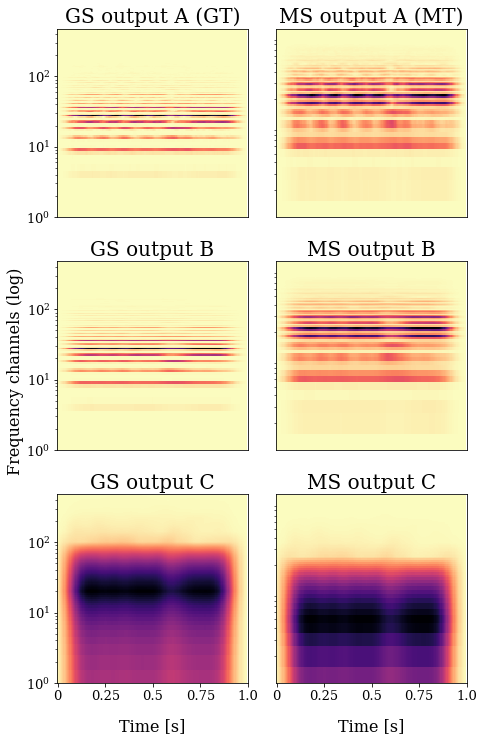

In [14]:
cmap='magma_r'

plt.rcParams.update({'font.size': 13})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

fig, axes = plt.subplots(3, 2, sharey=False, sharex=False, figsize=(7,10.5))

fig.text(0.04, 0.5, 'Frequency channels (log)', va='center', rotation='vertical', fontsize=16)

axes[0][0].imshow(GS_sample[0], aspect='auto', origin='lower', cmap=cmap)
axes[0][0].set_yscale('log')
axes[0][0].set_ybound(1, 480)
axes[0][0].set_xticks([])
axes[0][0].set_title('GS output A (GT)', fontsize=20)

axes[0][1].imshow(MS_sample[0], aspect='auto', origin='lower', cmap=cmap)
axes[0][1].set_yscale('log')
axes[0][1].set_ybound(1, 120)
axes[0][1].set_yticks([])
axes[0][1].set_xticks([])
axes[0][1].set_title('MS output A (MT)', fontsize=20)

axes[1][0].imshow(GS_sample[1], aspect='auto', origin='lower', cmap=cmap)
axes[1][0].set_yscale('log')
axes[1][0].set_ybound(1, 480)
axes[1][0].set_xticks([])
axes[1][0].set_title('GS output B', fontsize=20)

axes[1][1].imshow(MS_sample[1], aspect='auto', origin='lower', cmap=cmap)
axes[1][1].set_yscale('log')
axes[1][1].set_ybound(1, 120)
axes[1][1].set_yticks([])
axes[1][1].set_xticks([])
axes[1][1].set_title('MS output B', fontsize=20)

axes[2][0].imshow(GS_sample[2], aspect='auto', origin='lower', cmap=cmap)
axes[2][0].set_yscale('log')
axes[2][0].set_ybound(1, 480)
axes[2][0].set_xticks([0, 40, 80, 120, 160])
axes[2][0].set_xticklabels([0, 0.25, 0.5, 0.75, 1.0])
axes[2][0].set_xlabel('Time [s]', fontsize=16, labelpad=15)
axes[2][0].set_title('GS output C', fontsize=20)

axes[2][1].imshow(MS_sample[2], aspect='auto', origin='lower', cmap=cmap)
axes[2][1].set_yscale('log')
axes[2][1].set_ybound(1, 120)
axes[2][1].set_yticks([])
axes[2][1].set_xticks([0, 40, 80, 120, 160])
axes[2][1].set_xticklabels([0, 0.25, 0.5, 0.75, 1.0])
axes[2][1].set_xlabel('Time [s]', fontsize=16, labelpad=15)
axes[2][1].set_title('MS output C', fontsize=20)

fig.tight_layout(rect=[0.05, 0.0, 1, 1])
plt.savefig('experiments/sample_vis.pdf', dpi=100, bbox_inches='tight')
plt.show()

# 10. Definition of the Fully Convolutional Neural Network model

In [12]:
def dcnn_model(opt='sgd', bn_in=False, nkernel=64, lr=0.001, drop=0.0, 
               kr=None, decay=0.0, loss='categorical_crossentropy'):
    
    nkernel = int(nkernel)
    
    rep_shape = shapes[rep]
    inputs = Input(batch_shape=(None, *rep_shape))
    a = Permute((2,3,1))(inputs)

    var_pool = 1 if rep in ['MS', 'MT'] else 2
    reg_dens = regularizers.l2(kr)

    a = BatchNormalization(axis=-1)(a)
    a = Conv2D(nkernel, kernel_size=(3,3), strides=(1,1),padding='same', data_format='channels_last', activation='relu')(a)
    a = AveragePooling2D(pool_size=(var_pool, 2), strides=None, padding='same', data_format='channels_last')(a)

    a = Conv2D(nkernel, kernel_size=(3,3), strides=(1,1),padding='same', data_format='channels_last', activation='relu')(a)
    a = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same', data_format='channels_last')(a)

    a = Conv2D(nkernel, kernel_size=(3,3), strides=(1,1),padding='same', data_format='channels_last', activation='relu')(a)
    a = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same', data_format='channels_last')(a)

    a = Conv2D(8, kernel_size=(3,3), strides=(1,1),padding='same', data_format='channels_last', activation='relu')(a)
    a = AveragePooling2D(pool_size=(4, 4), strides=None, padding='same', data_format='channels_last')(a)

    a = Flatten()(a)
    outputs = Dense(6, kernel_regularizer=reg_dens, activation='softmax')(a)
    
    m =  Model(inputs, outputs)

    from keras.optimizers import SGD

    # Pick the optimizer
    if opt == 'sgd':
        optimizer = SGD(lr=lr, momentum=0.0, decay=decay, nesterov=False)
    elif opt == 'adam':
        optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999,
                         epsilon=None, decay=decay, amsgrad=False)

    m.compile(optimizer, loss=loss, metrics=['accuracy'])
    print(m.summary())
    return m

# 11. Training the model

Here you can search the hyperparameter space or set variants of the experiment.
You can either start training without pregenerating the batches. Or you can pregenerate them.

<font color='red'>Be aware that the very first epoch will take significantly longer than all others, if you do not pregenerate the batches, since all the batches are being created. If the batches were generated before, let's say on previous run or the previous experiment with the same tf_params, than it is not going to crete the batches again.</font>

In [ ]:
hyperparameter_space = np.array([
    # 0
    [64.00],    # N kernels
    [0.001],    # Lr
    [0.000],    # Decay
    [0.000],    # Dropout
    [0.000],    # Alpha
    [0.001],    # Kernel reg
    [None,],    # N project
]).T 

opt = 'adam'
space_element = hyperparameter_space[0]

# Total number of training batches is 1100
for rep in ['MT', 'MS', 'GS']:
    train_params.update({'rep': rep})
    for ntrain_batches in [1, 3, 5, 7, 9, 11, 55, 110, 550]:
        
        # In order to spend equal amount of computational effort on each of the experiments
        # here we specify for how many epochs it should run. The number of epochs is based
        # on number of weight updates done throughout the whole training. One weight
        # update is made after each batch. Here we limit the exps to 11k weight updates.
        # i.e. with ntrain_batches = 550, n_epochs = 20 we obtain 20 * 550 = 11000 weight updates.
        
        def get_n_epochs(ntrain_batches, weight_updates):
            return int(weight_updates / ntrain_batches)
        
        train_params.update({'epochs': get_n_epochs(ntrain_batches, train_params['weight_updates'])})
        
        variants= [
            ({'alpha': 0}, 'seed_{}_{}_{}_{}_catcross'.format(train_params['seed'], rep, ntrain_batches, opt))
        ]
        
        # Compute MT with Augmented target loss function
        if rep == 'MT':
            variants.append(
                ({'alpha': 10}, 'seed_{}_{}_{}_{}_atloss'.format(train_params['seed'], rep, ntrain_batches, opt)))
        
        
        for variant_params in variants:
            limited_train_seq = TimeFreqSequence(df=csv_split, set_name='train', labels_df=labels, class_col='instrument',
                                         rep=train_params['rep'], batch_size=train_params['batch_size'],
                                         cache_folder=paths['path_cache'], tf_params=tfparams,
                                         scaling_func=get_scaling_f(train_params['scaling']), 
                                         keep_in_ram=train_params['keep_in_ram'], 
                                         separate_inputs=train_params['separate_inputs'], 
                                         ntrain_batches=ntrain_batches)
            
            # Creating validation sequence
            valid_seq = TimeFreqSequence(df=csv_split, set_name='valid', labels_df=labels, class_col='instrument',
                                         rep=train_params['rep'], batch_size=train_params['batch_size'],
                                         cache_folder=paths['path_cache'], tf_params=tfparams,
                                         scaling_func=get_scaling_f(train_params['scaling']), 
                                         keep_in_ram=train_params['keep_in_ram'], 
                                         separate_inputs=train_params['separate_inputs'])

            # Creating test sequence
            test_seq = TimeFreqSequence(df=csv_split, set_name='test', labels_df=labels, class_col='instrument',
                                        rep=train_params['rep'], batch_size=train_params['batch_size'], 
                                        cache_folder=paths['path_cache'], tf_params=tfparams,
                                        scaling_func=get_scaling_f(train_params['scaling']), 
                                        keep_in_ram=train_params['keep_in_ram'], 
                                        separate_inputs=train_params['separate_inputs'])
            
            run_experiment(dcnn_model, opt='adam', i=0, trainseq=limited_train_seq, 
                           validseq=valid_seq, testseq=test_seq, features=features, 
                           train_params=train_params, space_element=space_element,
                           variant_params=variant_params[0], 
                           variant_name=variant_params[1], 
                           paths=paths)

# 12. Evaluating the experiment outputs

Here we create 3 result files:

* results-stats.csv
* results-permodel.csv
* results-all.csv

And multiple plots each comparing a pair of TF representations.

In [15]:
# Get the paths to log file of each experiment
logs = []
for root, dirs, files in os.walk('experiments'):
    for file in files:
        if file.endswith('training.csv'):
            logs.append(os.path.join(root, file))
                      
logs_TF = [[f for f in logs if '{}_'.format(tf) in f] for tf in tfparams.keys()]

# Put the experiments results into Pandas DataFrame
dfs = []
for tf in logs_TF:
    for log in tf:
        df = pd.read_csv(log)
        ids = log.split('/')[-2].replace('-', '_').split('_')

        df['rep'] = ids[4]
        df['variant'] = ids[-1]
        df['train_size'] = ids[5]
        df['epochs'] = df['epoch'].max() + 1
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.to_csv('experiments/results_all.csv', index=False, 
          columns=['rep', 'train_size', 'epochs', 'epoch', 'acc', 'loss', 'val_acc', 'val_loss', 'test_acc', 'test_loss', 'variant'])
df

epoch       acc      loss  test_acc  test_loss   val_acc  val_loss rep  \
0         0  0.179688  1.803409  0.228500   1.802839  0.229875  1.802849  GS   
1         1  0.226562  1.802379  0.234167   1.801940  0.236958  1.801981  GS   
2         2  0.234375  1.800917  0.234375   1.800694  0.236917  1.800765  GS   
3         3  0.226562  1.798821  0.237292   1.798890  0.241792  1.799007  GS   
4         4  0.234375  1.795758  0.235167   1.796454  0.240375  1.796656  GS   
5         5  0.226562  1.791405  0.238042   1.792991  0.243000  1.793336  GS   
6         6  0.242188  1.785184  0.239375   1.788426  0.243000  1.788994  GS   
7         7  0.257812  1.776665  0.241958   1.782586  0.244458  1.783483  GS   
8         8  0.273438  1.765220  0.241417   1.775577  0.241833  1.776950  GS   
9         9  0.273438  1.750572  0.240250   1.767328  0.239250  1.769362  GS   
10       10  0.265625  1.732483  0.248792   1.758337  0.249250  1.761241  GS   
11       11  0.273438  1.710719  0.258583   1.747554  0.264875  1.751645  GS   
12       12  0.250000  1.684872  0.291083   1.731667  0.295208  1.737373  GS   
13       13  0.320312  1.653502  0.302458   1.709106  0.297917  1.717000  GS   
14       14  0.335938  1.614554  0.312250   1.679815  0.304292  1.690598  GS   
15       15  0.359375  1.569220  0.328458   1.648111  0.313792  1.662133  GS   
16       16  0.343750  1.523869  0.336917   1.617773  0.321792  1.635313  GS   
17       17  0.367188  1.480245  0.366083   1.593601  0.346500  1.614803  GS   
18       18  0.414062  1.437657  0.428417   1.574005  0.410292  1.598555  GS   
19       19  0.437500  1.394907  0.440958   1.551359  0.422000  1.578833  GS   
20       20  0.468750  1.352182  0.452792   1.520871  0.431375  1.549684  GS   
21       21  0.507812  1.300358  0.459583   1.504307  0.436375  1.532215  GS   
22       22  0.500000  1.259327  0.480625   1.482303  0.462625  1.509308  GS   
23       23  0.546875  1.210667  0.485500   1.478695  0.464958  1.507580  GS   
24       24  0.570312  1.181966  0.517500   1.444194  0.494708  1.473760  GS   
25       25  0.585938  1.132314  0.526917   1.411609  0.505833  1.441137  GS   
26       26  0.585938  1.094766  0.531292   1.372711  0.513375  1.404428  GS   
27       27  0.601562  1.048730  0.529875   1.354622  0.511583  1.387694  GS   
28       28  0.593750  1.019822  0.551333   1.319105  0.535125  1.349353  GS   
29       29  0.648438  0.977676  0.579917   1.297200  0.560958  1.325671  GS   
...     ...       ...       ...       ...        ...       ...       ...  ..   
7865    170  0.954119  0.149904  0.929333   0.229293  0.923958  0.250978  MT   
7866    171  0.960795  0.134040  0.959167   0.144607  0.953500  0.158120  MT   
7867    172  0.980540  0.079806  0.950417   0.171572  0.947333  0.187699  MT   
7868    173  0.958097  0.135691  0.945583   0.185644  0.944417  0.194285  MT   
7869    174  0.973722  0.097028  0.956875   0.154392  0.951500  0.164948  MT   
7870    175  0.978977  0.083756  0.956667   0.149837  0.952167  0.168594  MT   
7871    176  0.980824  0.075687  0.958375   0.145018  0.955583  0.150005  MT   
7872    177  0.978835  0.079610  0.954125   0.154790  0.949417  0.163959  MT   
7873    178  0.965199  0.112511  0.938583   0.196194  0.938625  0.193517  MT   
7874    179  0.965199  0.109828  0.960167   0.142291  0.955917  0.151052  MT   
7875    180  0.962926  0.114748  0.950167   0.162836  0.947625  0.175519  MT   
7876    181  0.963494  0.123594  0.954167   0.159300  0.951083  0.167864  MT   
7877    182  0.979403  0.080550  0.955417   0.159395  0.954500  0.158802  MT   
7878    183  0.979261  0.076694  0.959333   0.141560  0.956917  0.149819  MT   
7879    184  0.974148  0.093213  0.955250   0.156584  0.954042  0.163737  MT   
7880    185  0.974574  0.089440  0.953625   0.157604  0.950208  0.159853  MT   
7881    186  0.977699  0.080329  0.952750   0.158198  0.951583  0.174212  MT   
7882    187  0.954545  0.170471  0.846000   0.606024  0.834708  0.667552  MT   
7883  

In [16]:
be = best_epochs(paths['path_experiments'], os.path.join(paths['path_experiments'], 'results_permodel.csv'))
be

batch_size scaling rep  separate_inputs  weight_updates  verbose  \
0000         128    None  GS            False           11000        1   
0000         128    None  GS            False           11000        1   
0000         128    None  GS            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MS            False           11000        1   
0000         128    None  MS            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MS            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  GS            False           11000        1   
0000         128    None  GS            False           11000        1   
0000         128    None  GS            False           11000        1   
0000         128    None  MS            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  GS            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MS            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MS            False           11000        1   
0000         128    None  GS            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MS            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MS            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  GS            False           11000        1   
0000         128    None  MS            False           11000        1   
0000         128    None  MT            False           11000        1   
0000         128    None  MT            False           11000        1   

      shuffle  seed  initial_epoch  keep_in_ram  \
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        False   
0000     True  5610              0        F

In [17]:
# Statistics based on all experiments on all train sizes
# Just for a reference
be['n_batches'] = train_params['weight_updates'] / be['epochs']
gbe = be[['acc', 'val_acc', 'test_acc', 'best_epoch']].groupby([be['rep'], be['alpha']])
gbem = gbe.mean()
gbes = gbe.std()[['acc', 'val_acc', 'test_acc']]
stats = pd.merge(left=gbem, right=gbes, how='left', left_index=True, right_index=True, suffixes=('_mean', '_std'))
stats.to_csv(os.path.join(paths['path_experiments'], 'results_stats.csv'))
stats

acc_mean  val_acc_mean  test_acc_mean  best_epoch   acc_std  \
rep alpha                                                                
GS  0      0.983250      0.896931       0.902014  139.666667  0.016462   
MS  0      0.948499      0.851917       0.858000  195.333333  0.050406   
MT  0      0.933980      0.845671       0.852847  199.777778  0.057525   
    10     0.959997      0.851625       0.855759  200.444444  0.031663   

           val_acc_std  test_acc_std  
rep alpha                             
GS  0         0.093207      0.090260  
MS  0         0.102302      0.100436  
MT  0         0.110818      0.108890  
    10        0.103500      0.101101

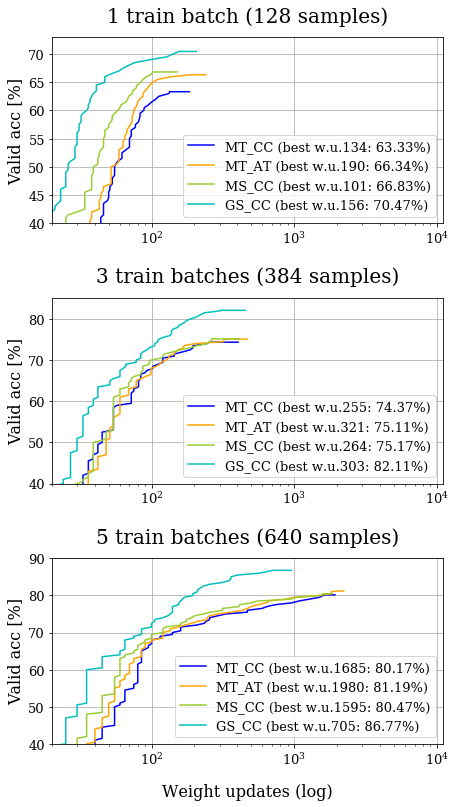

In [25]:
def get_steps(val_acc, steps, weight_updates_per_epoch=1):
    """
    Maps accuracy steps (e.g. [0.5, 0.7, 0.9]) to weight update after which
    the models' accuracy surpassed the aforementioned step.
    """
    
    dic = {}
    for s in steps:
        try:
            dic[s] = (np.where(val_acc >= s)[0][0] + 1) * weight_updates_per_epoch
        except:
            dic[s] = np.nan
    return dic

grp = df.groupby(['rep', 'train_size', 'variant'])

# sizes = [1, 3, 5, 7, 9, 11, 55, 110, 550]  # All the plots
sizes = [1, 3, 5]  # Interesting plots for the paper

# Organize the plot into a grid
grid = plt.GridSpec(len(sizes), 6, wspace=0.15, hspace=0.4)
locs = {0: (0, slice(0,6)), 
        1: (1, slice(0,6)), 
        2: (2, slice(0,6)), 
        3: (3, slice(0,6)), 
        4: (4, slice(0,6)),
        5: (5, slice(0,6)),
        6: (6, slice(0,6)),
        7: (7, slice(0,6)),
        8: (8, slice(0,6)),
        9: (9, slice(0,6)),
       }
plt.figure(figsize=(7, 13))


for i, s in enumerate(sizes):
    plt.subplot(grid[locs[i][0], locs[i][1]])

    for rep in ['MT', 'MS', 'GS']:
        for var, color in zip(['catcross', 'atloss'], ['blue', 'orange']):

            if rep == 'MS':
                color = 'yellowgreen'
            
            if rep == 'GS':
                color = 'c'

            try:
                scores = grp.get_group((rep, str(s), var))['val_acc']
            except:
                break
                
            steps = np.arange(0.2, 1.0, 0.005)  # Half percent steps
            best_wupdate = (np.argmax(scores.values) + 1) * s
            best_performance = float(np.max(scores.values))
            steps = np.sort(list(steps) + [best_performance])
            
            d = get_steps(scores, 
                          steps=steps, 
                          weight_updates_per_epoch=s)
            
            # Add last w.u (to show when the model was terminated)
            x = np.array(list(d.values()) + [len(scores) * s])
            y = np.array(list(d.keys()) + [best_performance])
            
            # Remove nans (nan in x if certain y threshold was not reached)
            y = y[np.isfinite(x)]
            x = x[np.isfinite(x)]
            
            plt.plot(x, y*100, color=color, label='{}_{} (best w.u.{}: {:.2f}%)'.format(
                rep,
                'AT' if var[0] == 'a' else 'CC', 
                best_wupdate,
                best_performance * 100))
    
    plt.rcParams.update({'font.size': 13})
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.grid(True)
    plt.xticks([10, 100, 1000, 10000])
    plt.xlim(20, 11000)
    plt.xscale('log')
    
    plt.title('{} train batch{} ({} samples)'.format(s, 'es' if i > 0 else '', s*128), fontsize=20, y=1.05)
    plt.ylim(40)
    plt.ylabel('Valid acc [%]', fontsize=16)  #(iterated by 0.5%)
    if i == 2:
        plt.xlabel('Weight updates (log)', fontsize=16, labelpad=16)
    plt.legend(loc='lower right')

plt.savefig('experiments/MT_vs_MS_vs_GS_reach.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

# Loading of a trained model

If you want to expect the weights of the trained models, use the following function for loading them.

In [5]:
from src.utils import load_checkpoint_model

# Example
exp_dir = os.path.join(paths['path_experiments'], 'exp-0000-seed_5610_MT_1_adam_atloss')
checkpoint_filename = '240-0.6504-0.9766.model'

checkpoint = load_checkpoint_model(
    directory=exp_dir,
    checkpoint_filename=checkpoint_filename,
    path_csv_labels=paths['path_csv_labels']
)

print(type(checkpoint))

<class 'keras.engine.training.Model'>


# Cost of computation

In the code bellow, we investigate the time needed for computing the MS and GS using our the Gabor-scattering library, which is our implementation in Python based on Scipy's implementation of STFT.It is important to say, that all such comparisons are only indicative, because the time is highly dependent on chosen parameters. So the final time is completely dependent on your specific usecase. With parameters that we have used in this experiment, the mean time necessary to compute the MS is 46.2102ms. The mean time necessary to compute the GS is approx. 15% more, 53.1484ms.

In [2]:
import timeit
# Measure the time to compute 1000 MS representations of 1s signal sampled at 44,1kHz with given parameters",
setup = '''
import numpy as np
from gabor_scattering import gs
wave = np.random.rand(44100)

tfparams = {
    'MS': {
        'l1_params' : {'nfft': 2000, 'nperseg': 2000, 'noverlap': 1750},
        'l2_params' : {'nfft': 25, 'nperseg': 25, 'noverlap': 20},
        'o2_params' : {'window_len': 5, 'mode': 'same', 'axis':1},
        'mel_params' : {'n_mels': 100},
        'shapes' : {'outA': (120, 160), 'outB': (120, 160), 'outC': (120, 160)},
        'return_outA': True,
        'return_outB': True, 
        'return_outC': True,
    }
}
'''
MStime = timeit.timeit("gs(wave, **tfparams['MS'])", number=1000, setup=setup)
print('Total time of computing 1000 MS representations: {:.4f} s.'.format(MStime))

Total time of computing 1000 MS representations: 46.2102 s.


In [1]:
import timeit
# Measure the time to compute 1000 GS representations of 1s signal sampled at 44,1kHz with given parameters",
setup = '''
import numpy as np
from gabor_scattering import gs
wave = np.random.rand(44100)

tfparams = {
    'GS': {
        'l1_params' : {'nfft': 2000, 'nperseg': 2000, 'noverlap': 1750},
        'l2_params' : {'nfft': 25, 'nperseg': 25, 'noverlap': 20},
        'o2_params' : {'window_len': 5, 'mode': 'same', 'axis':1},
        'shapes' : {'outA': (120, 160), 'outB': (120, 160), 'outC': (120, 160)},
        'return_outA': True,
        'return_outB': True, 
        'return_outC': True,
    }
}
'''
GStime = timeit.timeit("gs(wave, **tfparams['GS'])", number=1000, setup=setup)
print('Total time of computing 1000 GS representations: {:.4f} s.'.format(GStime))

Total time of computing 1000 GS representations: 53.1484 s.
